# Correlation, Causality and multiCollinearity

For a good explanation, see: 

https://www.otexts.org/fpp/5/7

Let's stop and check that out.

### Back to our BART data

In [40]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

height has been deprecated.



In [3]:
# This data has
bart = pd.read_csv('data/BARTEstimationFile.csv', parse_dates=['MONTH'], index_col='MONTH')
bart.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 177 entries, 2001-01-01 to 2015-09-01
Data columns (total 22 columns):
RIDERS                     177 non-null float64
STATIONS                   177 non-null int64
CASH_FARE_2010USD_BART     175 non-null float64
AVG_FARE_2010USD_BART      175 non-null float64
HH                         168 non-null float64
HH_0VEH                    168 non-null float64
POP                        168 non-null float64
WORKERS                    168 non-null float64
MEDIAN_HHINC_2010USD       168 non-null float64
SERVMILES_E_BART           177 non-null float64
TOTEMP                     171 non-null float64
RETAIL_EMP                 171 non-null float64
EDHEALTH_EMP               171 non-null float64
LEISURE_EMP                171 non-null float64
OTHER_EMP                  171 non-null float64
FUEL_PRICE_2010USD         171 non-null float64
FUEL_COST_2010USD          171 non-null float64
TOLL_BB_PK_2010USD         171 non-null float64
TOLL_BB_OP_201

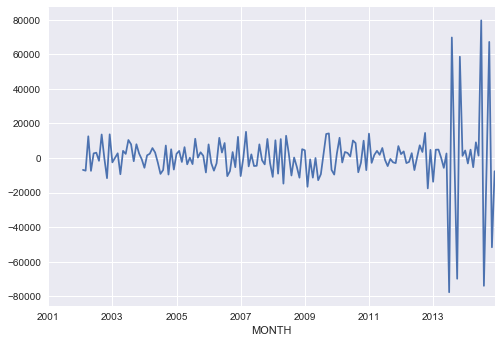

In [4]:
# drop missing values
bart = bart.dropna()

# calculate second difference
diff = bart - bart.shift(12)
diff2 = diff - diff.shift(1)
diff2['RIDERS'].plot()

In [5]:
# start from the variables we think are important

mod = smf.ols(formula='RIDERS ~ \
              SERVMILES_E_BART \
              + TOTEMP \
              + WORKERS \
              + CASH_FARE_2010USD_BART \
              + FUEL_COST_2010USD \
              + BART_STRIKE \
              - 1', 
              data=diff2[13:])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 RIDERS   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     127.8
Date:                Wed, 12 Apr 2017   Prob (F-statistic):           3.59e-56
Time:                        16:05:49   Log-Likelihood:                -1591.1
No. Observations:                 155   AIC:                             3194.
Df Residuals:                     149   BIC:                             3212.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
SERVMILES_E_BART           0

It seems like we might have multicollinearity issues.  There are some statistical tests for this, or we can examine the covariance matrix.  For now, let's see if we can figure out what's going on a bit more intuitively.  

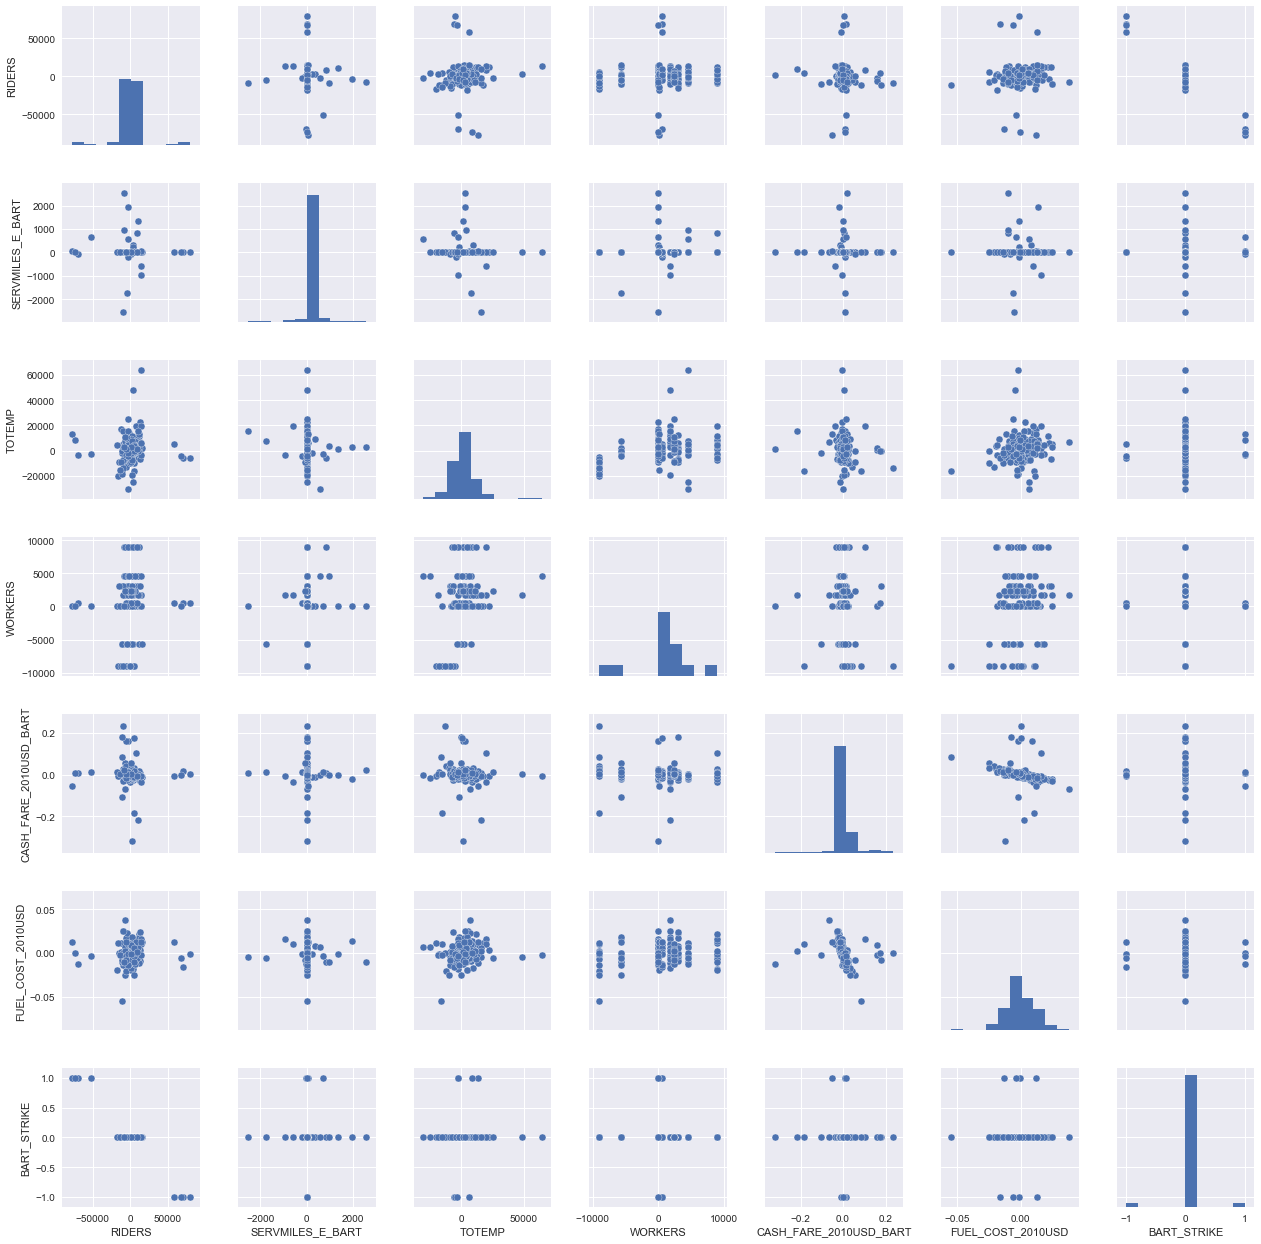

In [6]:
# a simple thing we can do is look at the data
#workers are located where employees live
#
fields = ['RIDERS', 'SERVMILES_E_BART', 'TOTEMP', 'WORKERS', 'CASH_FARE_2010USD_BART', 'FUEL_COST_2010USD', 'BART_STRIKE']

sns.pairplot(diff2[fields][13:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002B665FF5470>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000002B6661AB4E0>], dtype=object)

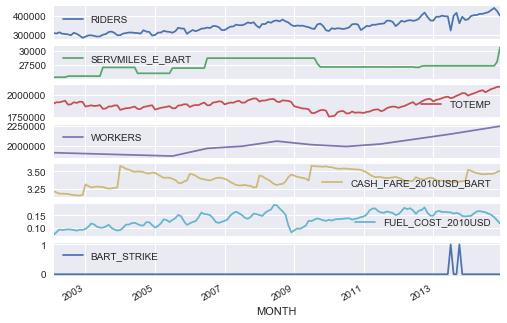

In [8]:
fields = ['RIDERS', 'SERVMILES_E_BART', 'TOTEMP', 'WORKERS', 'CASH_FARE_2010USD_BART', 'FUEL_COST_2010USD', 'BART_STRIKE']

bart[fields][13:].plot(subplots=True)

In [9]:
# workers and totemp seem to move together.  What if we drop one or the other? 

mod = smf.ols(formula='RIDERS ~ \
              SERVMILES_E_BART \
              + TOTEMP \
              + CASH_FARE_2010USD_BART \
              + FUEL_COST_2010USD \
              + BART_STRIKE \
              - 1', 
              data=diff2[13:])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 RIDERS   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     149.5
Date:                Wed, 12 Apr 2017   Prob (F-statistic):           2.01e-56
Time:                        16:06:05   Log-Likelihood:                -1593.1
No. Observations:                 155   AIC:                             3196.
Df Residuals:                     150   BIC:                             3211.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
SERVMILES_E_BART           0

In [10]:
# workers and totemp seem to move together.  What if we drop one or the other? 

mod = smf.ols(formula='RIDERS ~ \
              SERVMILES_E_BART \
              + WORKERS \
              + CASH_FARE_2010USD_BART \
              + FUEL_COST_2010USD \
              + BART_STRIKE \
              - 1', 
              data=diff2[13:])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 RIDERS   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     149.2
Date:                Wed, 12 Apr 2017   Prob (F-statistic):           2.30e-56
Time:                        16:06:08   Log-Likelihood:                -1593.3
No. Observations:                 155   AIC:                             3197.
Df Residuals:                     150   BIC:                             3212.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
SERVMILES_E_BART           0

Notice how the coefficients change.  One thing we can try is to specify a different variable that gets at a similar effect, but might be less collinear. 

In [11]:
# what if we substitute population for workers?

mod = smf.ols(formula='RIDERS ~ \
              SERVMILES_E_BART \
              + TOTEMP \
              + POP \
              + CASH_FARE_2010USD_BART \
              + FUEL_COST_2010USD \
              + BART_STRIKE \
              - 1', 
              data=diff2[13:])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 RIDERS   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     125.8
Date:                Wed, 12 Apr 2017   Prob (F-statistic):           9.68e-56
Time:                        16:06:24   Log-Likelihood:                -1592.1
No. Observations:                 155   AIC:                             3196.
Df Residuals:                     149   BIC:                             3214.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
SERVMILES_E_BART           0

In [12]:
# what if now drop the insignificant terms? 

mod = smf.ols(formula='RIDERS ~ \
              + TOTEMP \
              + BART_STRIKE \
              - 1', 
              data=diff2[13:])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 RIDERS   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     367.3
Date:                Wed, 12 Apr 2017   Prob (F-statistic):           3.93e-59
Time:                        16:06:27   Log-Likelihood:                -1595.5
No. Observations:                 155   AIC:                             3195.
Df Residuals:                     153   BIC:                             3201.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
TOTEMP          0.1645      0.055      2.998      

The R-squared is almost as good, but we can't predict what will happen if we change one of the other variables.  Sometimes we want to leave in an insignificant variable for theoretical or policy-sensitive reasons. 

In [13]:
# And what if we drop the BART_STRIKE variable

mod = smf.ols(formula='RIDERS ~ \
              + TOTEMP \
              - 1', 
              data=diff2[13:])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 RIDERS   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2332
Date:                Wed, 12 Apr 2017   Prob (F-statistic):              0.630
Time:                        16:06:29   Log-Likelihood:                -1731.7
No. Observations:                 155   AIC:                             3465.
Df Residuals:                     154   BIC:                             3468.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TOTEMP         0.0634      0.131      0.483      0.6

Wow, that's a lot different!  In this case, we've run into 'ommitted variable bias', where our coefficients are biased (and our model is lousy) because we're missing something important.  So what do we do?  

### Recommendations

Our friends at Northwestern (my alma mater!) have some good recommendations for how to 
proceed with these issues. 

Model Specification: Choosing the Right Variables for the Right Hand Side

https://www.kellogg.northwestern.edu/faculty/dranove/htm/dranove/coursepages/Mgmt%20469/choosing%20variables.pdf

They suggest: 

1) Always begin with a “core” set of predictors that have theoretical relevance, as well as any predictors whose effects you are specifically interested in. You may estimate a “quick and dirty” OLS model at this time. 

2) Finalize model specification issues (e.g., log vs. linear – to be discussed in a later note) 

3) Add additional predictors that you think might be relevant. You can add them one at a time or one “category” at a time (see next section). Check for the robustness of your initial findings. 

4) When adding predictors, you should keep all the original predictors in the model, even if they were not significant. Remember, omitted variable bias can cause significant predictors to appear to be insignificant. By adding more variables, your key predictors may become significant. 

5) At this point, you should know your robust findings. That is the main goal of your research. 

6) If you insist on producing a “final model”, then you should remove those additional predictors that were not remotely significant.


7) You can also remove core predictors if they remain insignificant and you need degrees of freedom. If you are not taxed for degrees of freedom, you may want to keep your core variables, if only to paint the entire picture for your audience.

### Homework

1. Read the model specification document referenced above. \
2. Given what you have learned today, develop a new BART ridership model.  Make that model an ARMA model with independent regressors.  Specify the regressors in a logical way, and make sure your data are stationary before you begin.  Justify your preferred model. 

In [24]:
diff2.BART_STRIKE.unique()

array([ nan,   0.,   1.,  -1.])

In [32]:
diff2_no_strike.head()

RIDERS  STATIONS  CASH_FARE_2010USD_BART  \
MONTH                                                      
2002-02-01  -6893.9950       0.0                0.000291   
2002-03-01  -7347.7410       0.0               -0.010593   
2002-04-01  12563.2143       0.0               -0.004941   
2002-05-01  -7457.7077       0.0                0.014539   
2002-06-01   2661.2723       0.0                0.003652   

            AVG_FARE_2010USD_BART            HH       HH_0VEH           POP  \
MONTH                                                                         
2002-02-01               0.000532 -9.999999e-04  0.000000e+00 -9.999997e-04   
2002-03-01              -0.007866  2.328306e-10  0.000000e+00  4.656613e-10   
2002-04-01              -0.003444 -2.328306e-10  1.000000e-04 -4.656613e-10   
2002-05-01               0.011387  0.000000e+00 -2.910383e-11  4.656613e-10   
2002-06-01               0.002903  0.000000e+00  0.000000e+00  1.000000e-03   

                 WORKERS  MEDIAN_HHINC_2010USD  SERVMILES_E_BART     ...       \
MONTH                                                                ...        
2002-02-01 -9.999999e-04              13.50480               0.0     ...        
2002-03-01  2.328306e-10            -270.33143               0.0     ...        
2002-04-01 -2.328306e-10            -121.55942               0.0     ...        
2002-05-01  0.000000e+00             382.50455               0.0     ...        
2002-06-01  0.000000e+00              97.47132               0.0     ...        

            EDHEALTH_EMP  LEISURE_EMP  OTHER_EMP  FUEL_PRICE_2010USD  \
MONTH                                                                  
2002-02-01       -2176.0      -1014.0     -581.0           -0.009729   
2002-03-01        1341.0        348.0    -1138.0            0.170677   
2002-04-01        1408.0       3923.0    16274.0            0.079985   
2002-05-01         612.0        726.0     8067.0           -0.135808   
2002-06-01       -4502.0        263.0     3255.0            0.037118   

            FUEL_COST_2010USD  TOLL_BB_PK_2010USD  TOLL_BB_OP_2010USD  \
MONTH                                                                   
2002-02-01          -0.000336            0.000222            0.000222   
2002-03-01           0.007850           -0.008087           -0.008087   
2002-04-01           0.003749           -0.003772           -0.003772   
2002-05-01          -0.006040            0.011099            0.011099   
2002-06-01           0.001807            0.002788            0.002788   

            TOLL_BB_CARPOOL_2010USD  CASUAL_CARPOOL  BART_STRIKE  
MONTH                                                             
2002-02-01                      0.0             0.0          0.0  
2002-03-01                      0.0             0.0          0.0  
2002-04-01                      0.0             0.0          0.0  
2002-05-01                      0.0             0.0          0.0  
2002-06-01                      0.0             0.0          0.0  

[5 rows x 22 columns]

In [33]:
data = diff2[diff2['BART_STRIKE'] == 0.0]

In [34]:
data.BART_STRIKE.unique()

array([ 0.])

In [35]:
mod = smf.ols(formula='RIDERS ~ \
              + TOTEMP \
              - 1', 
              data=data[13:])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 RIDERS   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     12.36
Date:                Wed, 12 Apr 2017   Prob (F-statistic):           0.000600
Time:                        16:15:48   Log-Likelihood:                -1374.0
No. Observations:                 134   AIC:                             2750.
Df Residuals:                     133   BIC:                             2753.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TOTEMP         0.1941      0.055      3.516      0.0

In [43]:
data['NON_WORKERS'] = data['POP'] - data['TOTEMP']

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [44]:
data.head()

RIDERS  STATIONS  CASH_FARE_2010USD_BART  \
MONTH                                                      
2002-02-01  -6893.9950       0.0                0.000291   
2002-03-01  -7347.7410       0.0               -0.010593   
2002-04-01  12563.2143       0.0               -0.004941   
2002-05-01  -7457.7077       0.0                0.014539   
2002-06-01   2661.2723       0.0                0.003652   

            AVG_FARE_2010USD_BART            HH       HH_0VEH           POP  \
MONTH                                                                         
2002-02-01               0.000532 -9.999999e-04  0.000000e+00 -9.999997e-04   
2002-03-01              -0.007866  2.328306e-10  0.000000e+00  4.656613e-10   
2002-04-01              -0.003444 -2.328306e-10  1.000000e-04 -4.656613e-10   
2002-05-01               0.011387  0.000000e+00 -2.910383e-11  4.656613e-10   
2002-06-01               0.002903  0.000000e+00  0.000000e+00  1.000000e-03   

                 WORKERS  MEDIAN_HHINC_2010USD  SERVMILES_E_BART     ...       \
MONTH                                                                ...        
2002-02-01 -9.999999e-04              13.50480               0.0     ...        
2002-03-01  2.328306e-10            -270.33143               0.0     ...        
2002-04-01 -2.328306e-10            -121.55942               0.0     ...        
2002-05-01  0.000000e+00             382.50455               0.0     ...        
2002-06-01  0.000000e+00              97.47132               0.0     ...        

            LEISURE_EMP  OTHER_EMP  FUEL_PRICE_2010USD  FUEL_COST_2010USD  \
MONTH                                                                       
2002-02-01      -1014.0     -581.0           -0.009729          -0.000336   
2002-03-01        348.0    -1138.0            0.170677           0.007850   
2002-04-01       3923.0    16274.0            0.079985           0.003749   
2002-05-01        726.0     8067.0           -0.135808          -0.006040   
2002-06-01        263.0     3255.0            0.037118           0.001807   

            TOLL_BB_PK_2010USD  TOLL_BB_OP_2010USD  TOLL_BB_CARPOOL_2010USD  \
MONTH                                                                         
2002-02-01            0.000222            0.000222                      0.0   
2002-03-01           -0.008087           -0.008087                      0.0   
2002-04-01           -0.003772           -0.003772                      0.0   
2002-05-01            0.011099            0.011099                      0.0   
2002-06-01            0.002788            0.002788                      0.0   

            CASUAL_CARPOOL  BART_STRIKE  NON_WORKERS  
MONTH                                                 
2002-02-01             0.0          0.0     3359.999  
2002-03-01             0.0          0.0    -1147.000  
2002-04-01             0.0          0.0   -22362.000  
2002-05-01             0.0          0.0   -10186.000  
2002-06-01             0.0          0.0     1865.001  

[5 rows x 23 columns]

In [49]:
data.TOLL_BB_CARPOOL_2010USD.unique()

array([  0.00000000e+00,   2.50051603e+00,  -3.44761300e-03,
        -1.45179100e-03,  -3.10367400e-03,  -1.04802600e-03,
        -4.27409000e-03,  -1.17908990e-02,  -1.21471990e-02,
        -2.37874020e-02,  -1.56082570e-02,  -1.13488910e-02,
         2.58648700e-03,  -2.50265402e+00,  -3.18803100e-03,
        -2.19657600e-03,   8.06986800e-03,   3.08073200e-03,
         1.02322810e-02,   1.20823100e-03,   1.60426000e-03,
         5.73926800e-03,   8.45053700e-03,   1.41324800e-02,
         8.97035000e-04,   6.01597300e-03,  -6.53304900e-03,
        -6.86354700e-03,  -4.04962200e-03,   9.18660300e-03,
         4.35933000e-04,   3.58186500e-03,  -8.68775200e-03,
         1.19251160e-02,   9.59502600e-03,  -6.95011600e-03,
        -9.08589600e-03,   7.80423500e-03,  -6.19339700e-03,
        -1.66921400e-03,   1.06444850e-02,  -8.73449200e-03,
        -1.00180950e-02,  -3.83667300e-03,   1.34330200e-03,
         9.84142000e-04,   1.29629900e-02])

In [48]:
for column in data.columns:
    print(column)

RIDERS
STATIONS
CASH_FARE_2010USD_BART
AVG_FARE_2010USD_BART
HH
HH_0VEH
POP
WORKERS
MEDIAN_HHINC_2010USD
SERVMILES_E_BART
TOTEMP
RETAIL_EMP
EDHEALTH_EMP
LEISURE_EMP
OTHER_EMP
FUEL_PRICE_2010USD
FUEL_COST_2010USD
TOLL_BB_PK_2010USD
TOLL_BB_OP_2010USD
TOLL_BB_CARPOOL_2010USD
CASUAL_CARPOOL
BART_STRIKE
NON_WORKERS


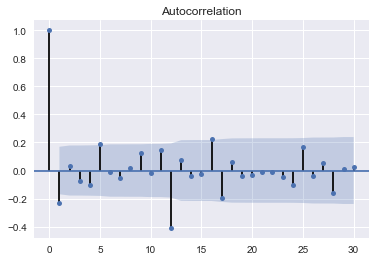

In [55]:
fig = sm.graphics.tsa.plot_acf(data['RIDERS'][13:], lags=30)

In [93]:
data['HH_VEH'] = data['HH'] - data['HH_0VEH']

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [101]:
mod = sm.tsa.SARIMAX(data['RIDERS'][13:], exog=data[['TOTEMP','FUEL_COST_2010USD']][13:], order=(2,0,0), seasonal_order=(0,0,1,12))
res = mod.fit()
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             RIDERS   No. Observations:                  134
Model:             SARIMAX(2, 0, 0)x(0, 0, 1, 12)   Log Likelihood               -1347.718
Date:                            Wed, 12 Apr 2017   AIC                           2707.436
Time:                                    17:45:02   BIC                           2724.823
Sample:                                03-01-2003   HQIC                          2714.502
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
TOTEMP                0.1860      0.066      2.834      0.005       0.057       0.315
FUEL_COST_2010

In [102]:
mod = sm.tsa.SARIMAX(data['RIDERS'][13:], exog=data[['TOTEMP','FUEL_COST_2010USD','CASH_FARE_2010USD_BART','TOLL_BB_OP_2010USD']][13:], order=(2,0,0), seasonal_order=(0,0,1,12))
res = mod.fit()
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             RIDERS   No. Observations:                  134
Model:             SARIMAX(2, 0, 0)x(0, 0, 1, 12)   Log Likelihood               -1346.495
Date:                            Wed, 12 Apr 2017   AIC                           2708.989
Time:                                    17:45:04   BIC                           2732.172
Sample:                                03-01-2003   HQIC                          2718.410
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
TOTEMP                     0.1775      0.065      2.722      0.006       0.050       0.305

In [ ]:
# What is the difference between ar.S.L12 and ar.L12 auto regressing in the seasonal order but how do you interpret it
# is it simply one is indexed automatically to 12 periods (or whatever you season index is set to)

#how do you interpret the exogenous variables
    #is it for 1 increase in the variable between years there is a (coefficient) increase/decrease in the number of 
    #bart riders between the same two years